checking Hypothesis class

In [1]:
from search import Hypothesis

factors = [lambda x: x.get('CNNaffinity')]
experiment = [[2, 10]]  # Single range

h = Hypothesis(factors, experiment)

# Test molecules
molecule_1 = {'CNNaffinity': 6.5}  # Within range
molecule_2 = {'CNNaffinity': 1.5}  # Outside range
molecule_3 = {'MolWt': 320}        # Missing CNNaffinity key
molecule_4 = {'MolWt': 501, 'CNNaffinity': 7.0} #Two keys both within range
molecule_5 = {'MolWt': 320, 'CNNaffinity': 7.0} #Two keys one within range

print(h(molecule_1))  # True
print(h(molecule_2))  # False
print(h(molecule_3))  # False
print(h(molecule_4))  # True
print(h(molecule_5))  # False

True
False
False
True
True


Patience based earlystopping of search

Iteration 1:
  Current Q = 0.9222, Best Q = 0.9222
  Candidate Q scores: [1.0174, 0.9264, 0.8929, 0.8871, 0.8333]
  Candidate chosen: 1.0174
  New best Q found!
----------------------------------------
Iteration 2:
  Current Q = 1.0174, Best Q = 1.0174
  Candidate Q scores: [1.1834, 1.1329, 1.0513, 1.0078, 0.9373]
  Candidate chosen: 1.1834
  New best Q found!
----------------------------------------
Iteration 3:
  Current Q = 1.1834, Best Q = 1.1834
  Candidate Q scores: [1.3045, 1.2395, 1.1857, 1.0802, 1.0653]
  Candidate chosen: 1.3045
  New best Q found!
----------------------------------------
Iteration 4:
  Current Q = 1.3045, Best Q = 1.3045
  Candidate Q scores: [1.5565, 1.5184, 1.5144, 1.4664, 1.2055]
  Candidate chosen: 1.5565
  New best Q found!
----------------------------------------
Iteration 5:
  Current Q = 1.5565, Best Q = 1.5565
  Candidate Q scores: [1.8048, 1.6996, 1.671, 1.5391, 1.3079]
  Candidate chosen: 1.8048
  New best Q found!
--------------------------------

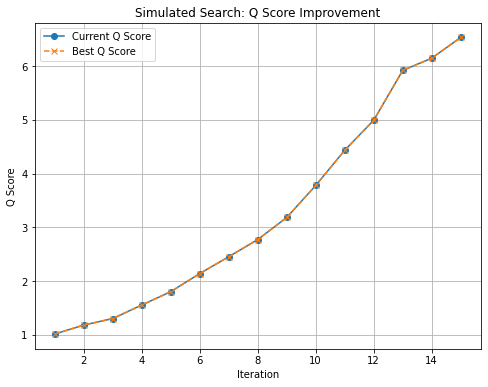

In [2]:
#!/usr/bin/env python3
"""
Simulation of the search process used in the molecule generation pipelines.
This simulation starts with a random initial Q score and in each iteration
generates candidate Q scores. A candidate is accepted only if it is within 10%
of the best Q score seen so far. A patience mechanism stops the search if there
are several iterations with no improvement.

A plot is generated at the end to show the evolution of the current and best Q scores.
"""

import random
import numpy as np
import matplotlib.pyplot as plt

def simulate_search(num_iterations=15, patience_limit=3, threshold=0.9):
    """
    Simulate the search loop.

    Parameters:
      num_iterations: Maximum number of iterations.
      patience_limit: Number of iterations allowed with no improvement.
      threshold: Candidate Q must be at least (threshold * best_Q) to be considered.
    
    Returns:
      iterations: List of iteration numbers.
      current_Q_history: List of Q values selected in each iteration.
      best_Q_history: List of best Q values seen so far.
    """
    # Start with an initial Q value (for simulation, choose a random value)
    current_Q = random.uniform(0.5, 1.0)
    best_Q = current_Q
    patience_counter = 0

    iterations = []
    current_Q_history = []
    best_Q_history = []

    for iteration in range(1, num_iterations + 1):
        # Simulate generating 5 candidate Q scores around the current value.
        # Here, we add some randomness by multiplying by a factor in [0.8, 1.2].
        candidates = [current_Q * random.uniform(0.8, 1.2) for _ in range(5)]
        candidates.sort(reverse=True)  # sort so that highest candidate is first

        print(f"Iteration {iteration}:")
        print(f"  Current Q = {current_Q:.4f}, Best Q = {best_Q:.4f}")
        print(f"  Candidate Q scores: {[round(c,4) for c in candidates]}")

        chosen = None
        for q in candidates:
            if q < best_Q * threshold:
                # Skip candidate if it is more than 10% lower than the best so far
                continue
            else:
                chosen = q
                break

        if chosen is None:
            print("  No candidate meets the threshold. Terminating search.")
            break

        print(f"  Candidate chosen: {chosen:.4f}")

        # Update best Q score if there is an improvement
        if chosen > best_Q:
            best_Q = chosen
            patience_counter = 0
            print("  New best Q found!")
        else:
            patience_counter += 1
            print(f"  No improvement over best Q. Patience counter: {patience_counter}/{patience_limit}")

        # Update the current Q and record the history
        current_Q = chosen
        iterations.append(iteration)
        current_Q_history.append(current_Q)
        best_Q_history.append(best_Q)

        if patience_counter >= patience_limit:
            print("  Patience limit reached. Terminating search.")
            break

        print("-" * 40)

    return iterations, current_Q_history, best_Q_history

def plot_results(iterations, current_Q_history, best_Q_history):
    plt.figure(figsize=(8, 6))
    plt.plot(iterations, current_Q_history, marker='o', label='Current Q Score')
    plt.plot(iterations, best_Q_history, marker='x', linestyle='--', label='Best Q Score')
    plt.xlabel('Iteration')
    plt.ylabel('Q Score')
    plt.title('Simulated Search: Q Score Improvement')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Run the simulation
    iterations, current_Q_history, best_Q_history = simulate_search(
        num_iterations=15,
        patience_limit=3,
        threshold=0.9  # Candidate Q must be at least 90% of best_Q
    )
    # Plot the results
    plot_results(iterations, current_Q_history, best_Q_history)

if __name__ == "__main__":
    main()

Latin Square based sampling

Single-Factor Case (CNNaffinity Intervals):

Single Factor LHS Intervals:
   Start   End
0    7.6   8.4
1    9.2  10.0
2    5.2   6.0
3    2.0   2.8
4    3.6   4.4

Multi-Factor Case (CNNaffinity & MolWt Intervals):

Multi Factor LHS Intervals:
                 CNNaffinity           MolWt
0                 [8.4, 9.2]  [100.0, 150.0]
1  [7.6000000000000005, 8.4]     [0.0, 50.0]
2                 [4.4, 5.2]  [150.0, 200.0]
3                 [5.2, 6.0]  [200.0, 250.0]
4                 [2.8, 3.6]   [50.0, 100.0]


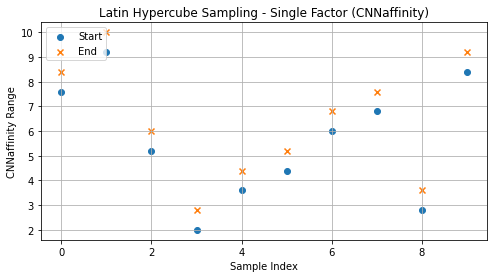

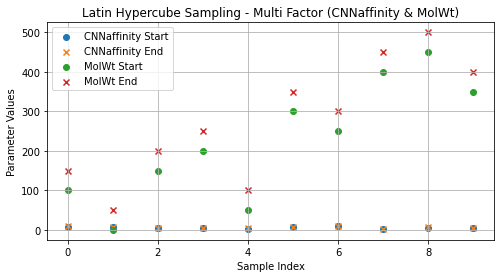

In [3]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

def display_dataframe_to_user(name, dataframe):
    print(f"\n{name}:")
    print(dataframe.head())

# Define parameters
s = 10  # Number of samples
single_factor_range = [2, 10]
multi_factor_ranges = {"CNNaffinity": [2, 10], "MolWt": [0, 500]}

# Single-factor case: LHS sampling
lhs_single = scipy.stats.qmc.LatinHypercube(d=1).random(n=s)
single_quantiles = np.linspace(single_factor_range[0], single_factor_range[1], s + 1)
single_factor_intervals = [
    [single_quantiles[int(sample * s)], single_quantiles[int(sample * s) + 1]]
    for sample in lhs_single.flatten()
]

# Multi-factor case: LHS sampling
num_factors = len(multi_factor_ranges)
lhs_multi = scipy.stats.qmc.LatinHypercube(d=num_factors).random(n=s)

multi_factor_intervals = []
for sample in lhs_multi:
    factor_intervals = {}
    for i, param in enumerate(multi_factor_ranges.keys()):
        quantiles = np.linspace(multi_factor_ranges[param][0], multi_factor_ranges[param][1], s + 1)
        index = int(sample[i] * s)
        factor_intervals[param] = [quantiles[index], quantiles[index + 1]]
    multi_factor_intervals.append(factor_intervals)

single_df = pd.DataFrame(single_factor_intervals, columns=["Start", "End"])
multi_df = pd.DataFrame(multi_factor_intervals)

print("Single-Factor Case (CNNaffinity Intervals):")
display_dataframe_to_user(name="Single Factor LHS Intervals", dataframe=single_df)

print("\nMulti-Factor Case (CNNaffinity & MolWt Intervals):")
display_dataframe_to_user(name="Multi Factor LHS Intervals", dataframe=multi_df)

# Plot Single Factor Sampling
plt.figure(figsize=(8, 4))
plt.scatter(range(len(single_factor_intervals)), [x[0] for x in single_factor_intervals], label="Start", marker='o')
plt.scatter(range(len(single_factor_intervals)), [x[1] for x in single_factor_intervals], label="End", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("CNNaffinity Range")
plt.title("Latin Hypercube Sampling - Single Factor (CNNaffinity)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Multi-Factor Sampling
plt.figure(figsize=(8, 4))
for i, param in enumerate(multi_factor_ranges.keys()):
    plt.scatter(range(len(multi_factor_intervals)), [x[param][0] for x in multi_factor_intervals], label=f"{param} Start", marker='o')
    plt.scatter(range(len(multi_factor_intervals)), [x[param][1] for x in multi_factor_intervals], label=f"{param} End", marker='x')

plt.xlabel("Sample Index")
plt.ylabel("Parameter Values")
plt.title("Latin Hypercube Sampling - Multi Factor (CNNaffinity & MolWt)")
plt.legend()
plt.grid(True)
plt.show()